 Group 1 already loaded and split the data , but  out of testing purpose, we are doing it again

# Test Gower distance

## Steps: 

1. Loads and splits  real dataset 

2.Loads and aligns the synthetic data

3. Computes Gower similarity

4. Outputs both:

- The most similar synthetic sample for the first test sample

In [7]:
!pip install ydata_profiling==4.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 26.0 MB/s eta 0

In [10]:
'''
This is a clean version of the notebook so far.
'''
import numpy as np
import pandas as pd
import gower
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Load the data
synth = pd.read_csv('synth.csv') 
original = pd.read_csv('real-data.csv')  

# Drop unnecessary id column
synth = synth.drop(columns=['id'])

# Backup synth dataset for future
synth_raw = synth.copy()

In [16]:
# Split off the test set (20%)
X_train, X_test = train_test_split(
    original,test_size=0.20, random_state=42)

In [19]:
# Main function to remove similarities
def remove_similar(X_test, synth, threshold=.14):
    to_remove = []
    removed_map = {}

    for i, row in X_test.iterrows():
        # Compute Gower distance between the real record and the synthetic data
        gower_matrix = gower.gower_matrix(row.to_frame().T, synth)
        # Find indices of synthetic records within the threshold
        matches = np.where(gower_matrix <= threshold)
        unique_indices = np.unique(matches[1])
        
        # Save the indices of the removed records
        for idx in unique_indices:
            removed_map.setdefault(idx, []).append(i)

        # Save removed indices for later analysis (number of removed records)    
        to_remove.extend(unique_indices)
    
    # Remove found similarities from synthetic data
    synth = synth.drop(index=to_remove)

    print(f"🧹 Number of unique indices to remove: {len(np.unique(to_remove))}")
    print(f"📦 Length of synth before: {len(synth_raw)}")
    print(f"✅ Length of synth after: {len(synth)}")
    print(f"🗑️  Total synth rows removed: {len(synth_raw) - len(synth)}")

    return synth, removed_map

In [13]:
# Here we test different thresholds

# Thresholds range
distance_thresholds = np.arange(0.1, 0.3, 0.02)

# Summary in different thresholds and number of removed synthetic records
summary = []

for threshold in distance_thresholds:
    print("\n" + "="*40)
    print(f"Threshold: {threshold}")
    print("="*40)

    synth_clean, removed_map = remove_similar(X_test, synth, threshold=threshold)
    summary.append([threshold, len(removed_map)])
    print("-"*40 + "\n")
    print(f"Removed: {len(removed_map)}")
    print("="*40 + "\n")


Threshold: 0.1
🧹 Number of unique indices to remove: 133
📦 Length of synth before: 20758
✅ Length of synth after: 20625
🗑️  Total synth rows removed: 133
----------------------------------------

Removed: 133


Threshold: 0.12000000000000001
🧹 Number of unique indices to remove: 467
📦 Length of synth before: 20758
✅ Length of synth after: 20291
🗑️  Total synth rows removed: 467
----------------------------------------

Removed: 467


Threshold: 0.14
🧹 Number of unique indices to remove: 467
📦 Length of synth before: 20758
✅ Length of synth after: 20291
🗑️  Total synth rows removed: 467
----------------------------------------

Removed: 467


Threshold: 0.16000000000000003
🧹 Number of unique indices to remove: 467
📦 Length of synth before: 20758
✅ Length of synth after: 20291
🗑️  Total synth rows removed: 467
----------------------------------------

Removed: 467


Threshold: 0.18000000000000002
🧹 Number of unique indices to remove: 1867
📦 Length of synth before: 20758
✅ Length of synt

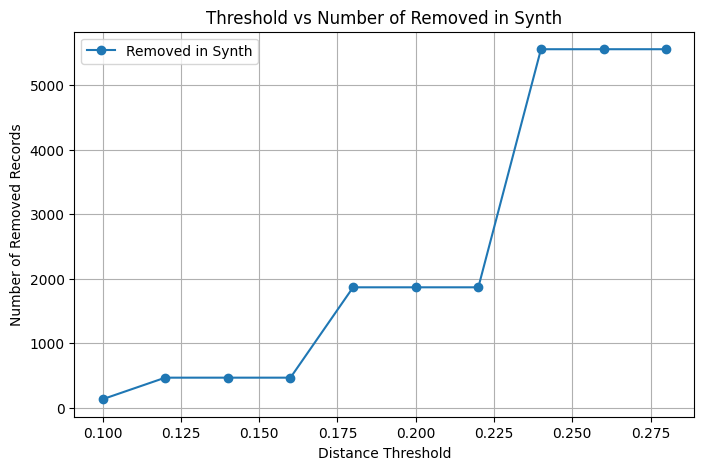

In [16]:
# Unpack summary into separate lists
thresholds = [row[0] for row in summary]
num_removed_synth = [row[1] for row in summary]

# Threshold vs Number of Removed in Synth
plt.figure(figsize=(8, 5))
plt.plot(thresholds, num_removed_synth, marker='o', label="Removed in Synth")
plt.title("Threshold vs Number of Removed in Synth")
plt.xlabel("Distance Threshold")
plt.ylabel("Number of Removed Records")
plt.grid(True)
plt.legend()
plt.show()

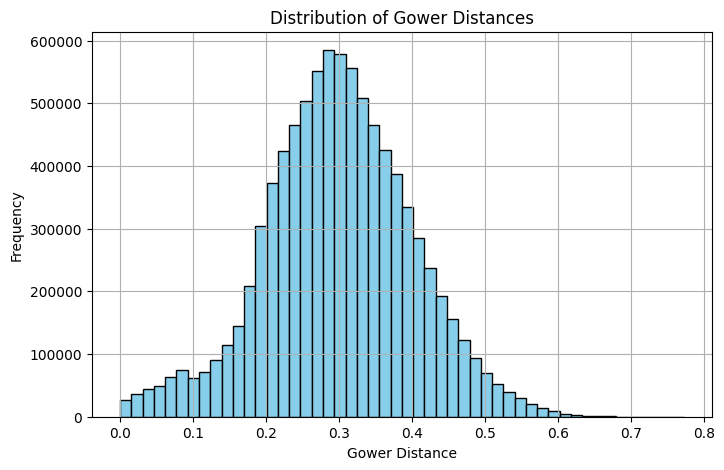

In [19]:
# Compute a global gower distance matrix
gower_matrix = gower.gower_matrix(X_test, synth_raw)

# Plot the distribution of gower distances
plt.figure(figsize=(8, 5))
plt.hist(gower_matrix.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Gower Distances')
plt.xlabel('Gower Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

###  Compute distances with 0.15 and 0.2

Compare distributions of synthetic dataset before and after similarities removal

In [25]:
synth_clean_15, removed_map = remove_similar(X_test, synth, threshold=0.15)
synth_clean_20, removed_map = remove_similar(X_test, synth, threshold=0.2)

profile_before = ProfileReport(synth_raw)
profile_before.to_file('./gower_reports/synth_raw.html')

profile_after_15 = ProfileReport(synth_clean_15)
profile_after_15.to_file('./gower_reports/synth_clean_15.html')

profile_after_20 = ProfileReport(synth_clean_20)
profile_after_20.to_file('./gower_reports/synth_clean_20.html')



🧹 Number of unique indices to remove: 467
📦 Length of synth before: 20758
✅ Length of synth after: 20291
🗑️  Total synth rows removed: 467
🧹 Number of unique indices to remove: 1867
📦 Length of synth before: 20758
✅ Length of synth after: 18891
🗑️  Total synth rows removed: 1867
Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


## Below are the drafts:

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import gower
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and copy real data safely
try:
    real_data_new = pd.read_csv("real-data.csv", on_bad_lines='skip').copy()
except Exception as e:
    print("Error loading real-data.csv:", e)
    raise

# Step 2: Separate features and target
X = real_data_new.drop(columns='NObeyesdad').copy()
y = real_data_new['NObeyesdad'].copy()

# Step 3: Create test, train, val splits 
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Step 4: Load synthetic data safely
try:
    synthetic_data = pd.read_csv("synthetic-data.csv", on_bad_lines='skip').copy()
except Exception as e:
    print("Error loading synthetic-data.csv:", e)
    raise

# Step 5: Align synthetic columns
synthetic_data = synthetic_data[X_test.columns].copy()

# Step 6: Compute Gower similarity
similarity_matrix = gower.gower_matrix(X_test, synthetic_data)

# Step 7: Apply threshold and show only matches found
threshold = 0.73  # Set your desired threshold

for i in range(len(X_test)):
    similarities = similarity_matrix[i]
    matches = np.where(similarities >= threshold)[0]

    if len(matches) > 0:
        print(f"\nTest sample {i} – {len(matches)} synthetic match(es) with similarity ≥ {threshold}:")
        #print(synthetic_data.iloc[matches])
        print("Similarity scores:", similarities[matches])



Test sample 9 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.74529946]

Test sample 19 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7822733]

Test sample 93 – 8 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7468422  0.730499   0.7422455  0.73679125 0.7482039  0.7450177
 0.76884997 0.7476264 ]

Test sample 304 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.73046803]

Test sample 367 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7445419]

Test sample 387 – 1 synthetic match(es) with similarity ≥ 0.73:
Similarity scores: [0.7536432]


In [11]:
import numpy as np
import pandas as pd
import gower


synth = pd.read_csv('synth.csv')
original = pd.read_csv('real-data.csv')

synth = synth.drop(columns=['id'])
synth_raw = synth.copy()

In [4]:
# Check how gowers distance works on one data sample

top_n = 5
summary = []

for i, row in original.iterrows():
    gower_matrix = gower.gower_matrix(row.to_frame().T, synth)

    # Sort by similarity (lower distance = more similar)
    top_matches = gower_matrix.argsort()[0][:top_n]
    bot_matches = gower_matrix.argsort()[0][len(gower_matrix) - top_n:]

    for n, j in enumerate(top_matches):
        match = synth.iloc[j]
        no_match = synth.iloc[bot_matches[n]]
        distance = gower_matrix[0][j]
        distance_bad = gower_matrix[0][bot_matches[n]]

        print("=" * 60)
        print(f"🎯 Test Sample (ID {i}):")
        print(row.to_frame().T.to_string(index=False))
        print("\n✅ Closest Synthetic Match:")
        print(match.to_frame().T.to_string(index=False))
        print(f"\n📏 Gower Distance: {distance:.4f}")

        print("\n❌ Distant (No Match) Example:")
        print(no_match.to_frame().T.to_string(index=False))
        
        print(f"\n📏 Gower Distance Bad: {distance_bad:.4f}")
        print("=" * 60 + "\n")

        #similarities = similarity_matrix[i]
        summary.append({
            "original_id": i,
            "synth_id": j,
            "distance": distance,
            "original_row": row.to_dict(),
            "synth_row": match.to_dict()
        })

    break  # remove this break to run for all rows


🎯 Test Sample (ID 0):
Gender   Age Height Weight family_history_with_overweight FAVC FCVC  NCP      CAEC SMOKE CH2O SCC  FAF  TUE CALC                MTRANS    NObeyesdad
Female  21.0   1.62   64.0                            yes   no  2.0  3.0 Sometimes    no  2.0  no  0.0  1.0   no Public_Transportation Normal_Weight

✅ Closest Synthetic Match:
Gender   Age Height Weight family_history_with_overweight FAVC FCVC  NCP      CAEC SMOKE CH2O SCC  FAF  TUE CALC                MTRANS    NObeyesdad
Female  21.0   1.62   60.0                            yes  yes  2.0  3.0 Sometimes    no  2.0  no  0.0  1.0   no Public_Transportation Normal_Weight

📏 Gower Distance: 0.1176

❌ Distant (No Match) Example:
Gender   Age Height Weight family_history_with_overweight FAVC FCVC  NCP      CAEC SMOKE CH2O SCC  FAF  TUE      CALC  MTRANS         NObeyesdad
  Male  19.0    1.8   85.0                             no  yes  3.0  4.0 Sometimes    no  3.0  no  2.0  0.0 Sometimes Walking Overweight_Level_I

📏 Gowe

IndexError: index 4 is out of bounds for axis 0 with size 4

splitting the dataset so that we can see the similarities between the test set and synth set

In [15]:
from sklearn.model_selection import train_test_split

# Split off the test set (20%)
X_train, X_test = train_test_split(
    original,test_size=0.20, random_state=42)

We calculate Gower's distance

In [25]:
# Try different thresholds, 
# from 0.01 to 0.1 - similar, 
# from 0.1 to 0.2 - high similarity
distance_thresholds = np.arange(0.01, 0.2, 0.01)

summary = []
distinct_dist = []

# Precompute full gower distance matrix
gower_matrix = gower.gower_matrix(X_test, synth)
# print(gower_matrix.shape)


for threshold in distance_thresholds:
    # Count how many synth records are within threshold for each original record
    matches = np.where(gower_matrix <= threshold)
 
    # Get unique corresponding synth indices
    unique_indices = np.unique(matches[1])  
    # Get unique original indices
    original_indices = matches[0][np.isin(matches[1], unique_indices)]

    print(len(original_indices), len(unique_indices))
    break
    summary.append([threshold, len(unique_indices)])

    distinct_dist.append(np.unique(gower_matrix[gower_matrix <= threshold]))
    

#---------------



14230 2917


We plot the number of unique matches that have to be removed based on the threshold

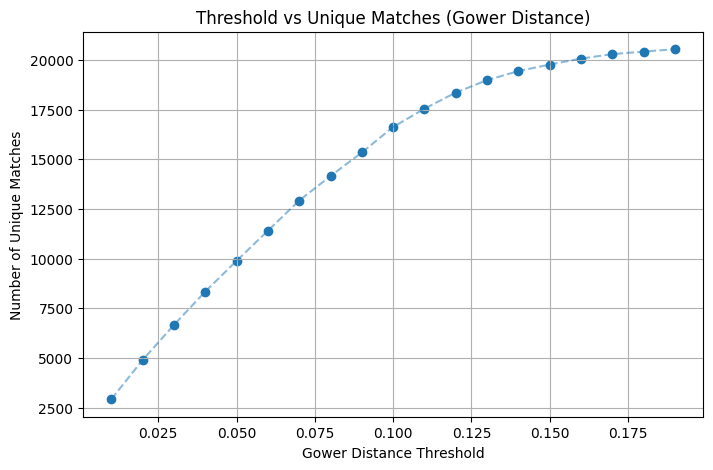

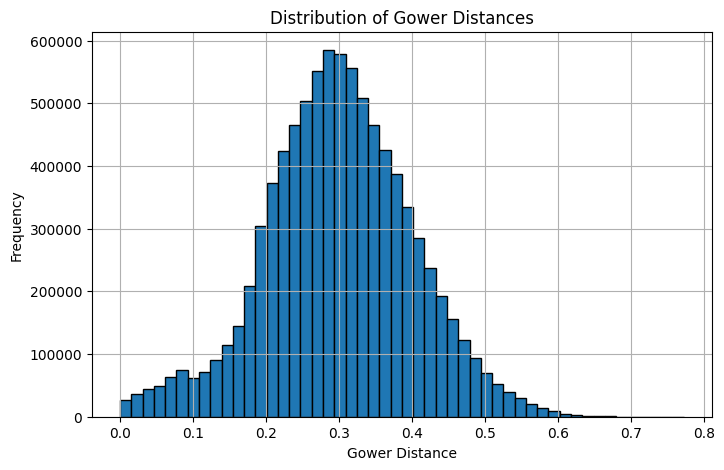

In [10]:
import matplotlib.pyplot as plt


distance_matrix = gower_matrix.copy()


def plot_threshold_vs_matches(summary):
    thresholds = [item[0] for item in summary]
    unique_counts = [item[1] for item in summary]

    plt.figure(figsize=(8, 5))
    plt.scatter(thresholds, unique_counts)
    plt.plot(thresholds, unique_counts, linestyle='--', alpha=0.5)
    plt.xlabel("Gower Distance Threshold")
    plt.ylabel("Number of Unique Matches")
    plt.title("Threshold vs Unique Matches (Gower Distance)")
    plt.grid(True)
    plt.show()

plot_threshold_vs_matches(summary)

all_distances = gower_matrix.flatten()

plt.figure(figsize=(8, 5))
plt.hist(all_distances, bins=50, edgecolor='black')
plt.xlabel("Gower Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Gower Distances")
plt.grid(True)
plt.show()


#plot_dis_mat_plot(distance_matrix)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a441f35e-4b4c-4c50-b56a-1aea6b800ed8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>